In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import re
import matplotlib.pyplot as plt

# Step1.데이터 다운로드

In [2]:


txt_file_path = '.\\data\\lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당


# Step2.데이터 읽어오기

In [3]:

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r",encoding='UTF8') as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


# Step 3. 데이터 정제

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. <br>
너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.<br>
그래서 이번에는 문장을 __토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기__ 를 권합니다.<br>

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # 토큰개수가 15개 넘어가는 문장을 학습데이터에서 제외
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>',
 '<start> had some bad love <end>',
 '<start> ooh , ooh looking for some affirmation <end>']

In [6]:
# 정제된 데이터 중에서 토큰개수가 15보다 큰 경우가 존재하는 지 확인해봅니다.
for i in corpus:
    if len(i.split()) > 15:
        print(i)

# Step 4. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리하세요!<br>

tokenize() 함수로 데이터를 Tensor로 변환한 후,<br>
sklearn 모듈의 train_test_split() 함수를 사용해 <br>
훈련 데이터와 평가 데이터를 분리하도록 하겠습니다.<br>
__단어장의 크기는 12,000 이상__ 으로 설정하세요!<br>
__총 데이터의 20%__ 를 평가 데이터셋으로 사용해 주세요!<br>

In [7]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 290  28 ...   0   0   0]
 [  2 219  13 ...   0   0   0]
 [  2  25  15 ...   0   0   0]
 ...
 [  2  21  77 ...   0   0   0]
 [  2  41  26 ...   0   0   0]
 [  2  21  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x000001E37F6EB6D0>


In [8]:
len(tokenizer.word_index)

25663

In [9]:
tensor.shape

(156013, 15)

In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2  290   28   94 4486    3    0    0    0    0    0    0    0    0]
[ 290   28   94 4486    3    0    0    0    0    0    0    0    0    0]


In [11]:
tgt_input.shape

(156013, 14)

In [12]:
src_input.shape

(156013, 14)

### (enc_train,enc_val)학습데이터 80%, (dec_train,dec_val)평가데이터 20%로 데이터 나누기<br>

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
enc_train, dec_train, enc_val, dec_val = \
    train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)

In [14]:
enc_train.shape

(124810, 14)

In [15]:
enc_val.shape

(124810, 14)

In [16]:
dec_train.shape

(31203, 14)

In [17]:
 dec_val.shape

(31203, 14)

# Step 5. 인공지능 만들기
- 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!<br>

### Training dataset 만들기<br>

In [18]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 12000개로 선언했기 때문에, tokenizer.num_words의 값은 12000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
enc_dataset = tf.data.Dataset.from_tensor_slices((enc_train, enc_val))
enc_dataset = enc_dataset.shuffle(BUFFER_SIZE)
enc_dataset = enc_dataset.batch(BATCH_SIZE, drop_remainder=True)
enc_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### Validation dataset만들기<br>

In [19]:
dec_dataset = tf.data.Dataset.from_tensor_slices((dec_train, dec_val))
dec_dataset = dec_dataset.shuffle(len(dec_train))
dec_dataset = dec_dataset.batch(BATCH_SIZE, drop_remainder=True)

### embedding_size 계산하기<br>
```
if num_categories <= 1000 :
    embedding_dimensions = min(500, num_categories/2) # 둘 중 최소값
else: # num_categories > 1000 일때
    embedding_dimensions = 75.6496 * np.log(num_categories + 176.623) - 41.4457

return int(embedding_dimensions)
```

In [20]:
import numpy as np
def get_embedding_size(num_categories):
    #embedding_dimensions =  num_categories**0.25
    
    if num_categories <= 1000 :
        embedding_dimensions = min(500, num_categories/2)
    # num_categories > 1000 일때
    else:
        embedding_dimensions = 75.6496 * np.log(num_categories + 176.623) - 41.4457
    
    return int(embedding_dimensions)

embedding_size = get_embedding_size(tokenizer.num_words + 1)
embedding_size      # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.

670

### LSTM hidden layer(Nh) 개수 계산하기<br>
$Nh = \frac{Ns}{(α∗(Ni+No))}$
```
Ni = 입력뉴런의 개수 (embedding_size)
No = 출력뉴런의 개수 (12000 )
Ns = 학습데이터 집합에서 샘플의 개수 (학습데이터개수 * embedding_size)
α = 임의의 스케일 요소 (일반적으로 2 사용)
```

In [21]:
def get_hidden_count(n_input, n_output, n_sample, alpha=2):
    n_hidden = n_sample / (alpha*(n_input + n_output))
    return int(n_hidden)

hidden_size = get_hidden_count(n_input=embedding_size,n_output=tokenizer.num_words + 1, n_sample=BUFFER_SIZE*embedding_size)
hidden_size  # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.

3299

In [22]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다.
        # input_dim : 어휘의 개수 --> 12000 +1
        # output_dim: 각 단어의 벡터 길이 -->
        # input_length: 시퀀스의 최대 길이
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,input_length=14) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
#embedding_size # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
#hidden_size # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [24]:
%%time
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy']) # 손실함수와 훈련과정을 설정했다.
history = model.fit(x=enc_dataset,validation_data=dec_dataset, epochs=10) # 만들어둔 데이터셋으로 모델을 학습한다. 10번 학습을 반복하겠다는 의미다.

Epoch 1/10
487/487 [==============================] - 357s 571ms/step - loss: 3.2762 - accuracy: 0.5022 - val_loss: 2.9490 - val_accuracy: 0.5256
Epoch 2/10
487/487 [==============================] - 278s 571ms/step - loss: 2.7814 - accuracy: 0.5377 - val_loss: 2.7250 - val_accuracy: 0.5440
Epoch 3/10
487/487 [==============================] - 278s 571ms/step - loss: 2.5045 - accuracy: 0.5602 - val_loss: 2.5521 - val_accuracy: 0.5647
Epoch 4/10
487/487 [==============================] - 278s 570ms/step - loss: 2.2299 - accuracy: 0.5889 - val_loss: 2.4183 - val_accuracy: 0.5853
Epoch 5/10
487/487 [==============================] - 278s 570ms/step - loss: 1.9592 - accuracy: 0.6242 - val_loss: 2.3163 - val_accuracy: 0.6055
Epoch 6/10
487/487 [==============================] - 278s 571ms/step - loss: 1.7026 - accuracy: 0.6653 - val_loss: 2.2364 - val_accuracy: 0.6253
Epoch 7/10
487/487 [==============================] - 278s 571ms/step - loss: 1.4716 - accuracy: 0.7076 - val_loss: 2.1840 -

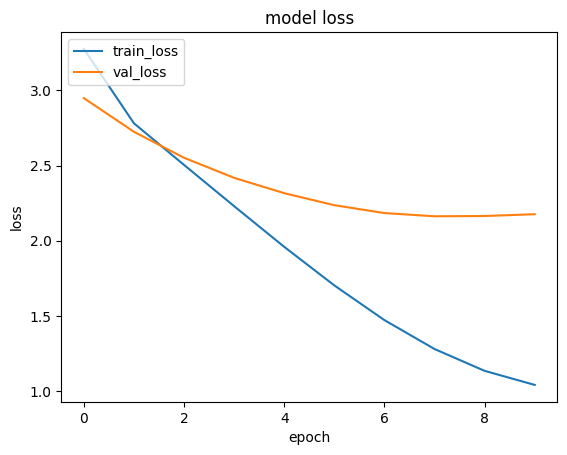

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

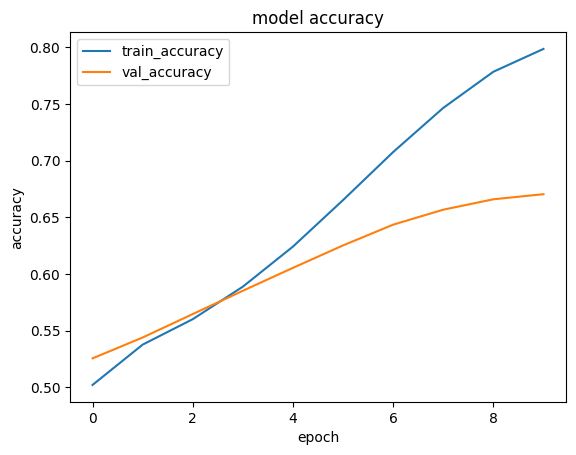

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [27]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [28]:
generate_text(model, tokenizer, init_sentence="<start> I love", max_len=20)

'<start> i love you so , <end> '